In [10]:
import sys, os

path2add = os.path.normpath(
    os.path.abspath(os.path.join(os.path.dirname("__file__"), os.path.pardir, "utils"))
)
if path2add not in sys.path:
    sys.path.append(path2add)

In [11]:
from utils.utils import mean_confidence_interval

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ranksums
from scipy.stats import kstest
from scipy.stats import bartlett

In [13]:
data_file = os.path.join(os.getcwd(), 'data', 'cookie_cats.csv')

try:
    df = pd.read_csv(data_file)
    print(df.head())
except FileNotFoundError:
    print(f"File not found: {data_file}")
    print("Please check the path and ensure the file exists.")

   userid  version  sum_gamerounds  retention_1  retention_7
0     116  gate_30               3        False        False
1     337  gate_30              38         True        False
2     377  gate_40             165         True        False
3     483  gate_40               1        False        False
4     488  gate_40             179         True         True


In [14]:
df

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
...,...,...,...,...,...
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [16]:
print(df.isnull().sum())

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64


Data contains no empty values

In [17]:
print(df.duplicated().sum())

0


Data contains no duplicates

In [18]:
df.groupby("version").agg({"sum_gamerounds" : ["mean","max","count"]})

sum_gamerounds              
                  mean    max  count
version                             
gate_30      52.456264  49854  44700
gate_40      51.298776   2640  45489

It looks like there is roughly the same number of players in each group.

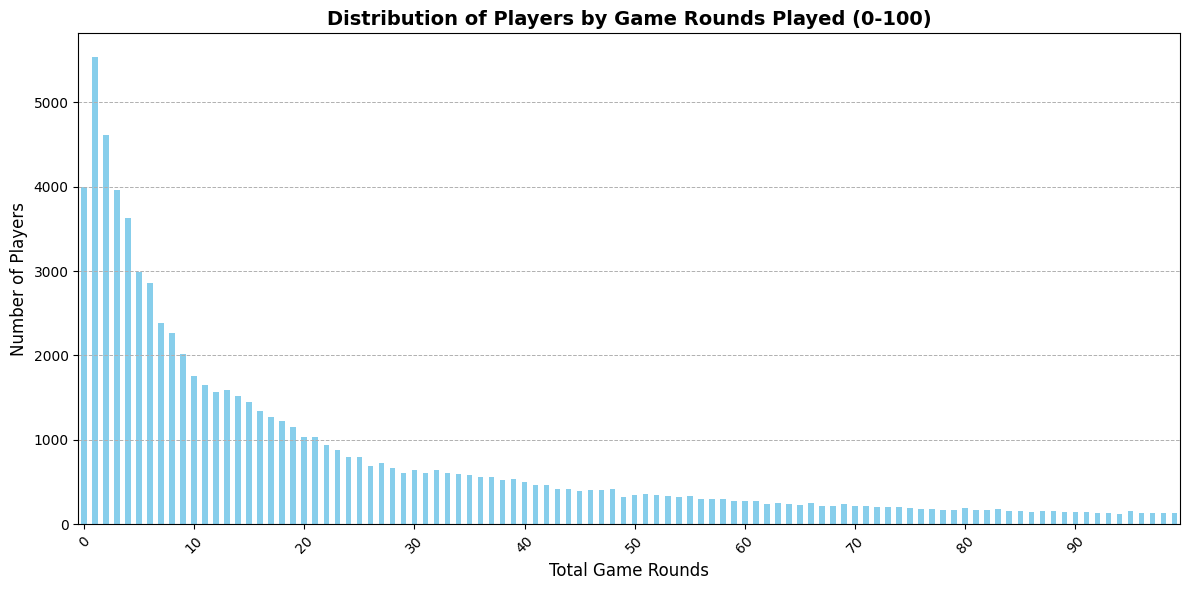

In [19]:
plot_df = df.groupby("sum_gamerounds")["userid"].count()

fig, ax = plt.subplots(figsize=(12, 6))
plot_df.head(100).plot(kind='bar', ax=ax, color='skyblue')

ax.set_xticks(range(0, 100, 10))
ax.set_xticklabels(range(0, 100, 10), rotation=45)

ax.set_title("Distribution of Players by Game Rounds Played (0-100)", fontweight="bold", fontsize=14)
ax.set_xlabel("Total Game Rounds", fontsize=12)
ax.set_ylabel("Number of Players", fontsize=12)

plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.tight_layout()

plt.show()

We are able to see that some players have never played the game.

In [20]:
df[df["sum_gamerounds"]== 0]["userid"].count()

3994

In [21]:
df_retention = df[["retention_1", "retention_7"]].mean() * 100

retention_1_day = round(df_retention[0], 2)
retention_7_day = round(df_retention[1], 2)

print(f"1-day retention ratio: {retention_1_day}%")
print(f"7-days retention ratio: {retention_7_day}%")

1-day retention ratio: 44.52%
7-days retention ratio: 18.61%


This means that a little less than half of the players come back one day\
after installing the game, and 18 percent of the players come back 7 days after installing the game.

In [22]:
df_retention_ab = df.groupby("version").agg({
    "userid": "count",
    "retention_1": "mean",
    "retention_7": "mean",
    "sum_gamerounds": "sum"
})

df_retention_ab

,userid,retention_1,retention_7,sum_gamerounds
version,,,,
gate_30,44700,0.448188,0.190201,2344795
gate_40,45489,0.442283,0.182000,2333530


- The 1-day retention rate for both groups is very close, with\
gate_30 slightly higher at 44.82% compared to gate_40 at 44.23%.
- The 7-day retention rate is also slightly higher for gate_30\
at 19.02% compared to gate_40 at 18.20%.

### Checking Normality Assumption (Kolmogorov-Smirnov Test)
- H0: The data follows a normal distribution.
- H1: The data does not follow a normal distribution.

In [23]:
test_stat, pvalue = kstest(df.loc[df["version"] == "gate_30", "sum_gamerounds"], 'norm')
print("Kolmogorov-Smirnov Test for gate_30 - Test Stat = %.4f, p-value = %.4f" % (test_stat, pvalue))

test_stat, pvalue = kstest(df.loc[df["version"] == "gate_40", "sum_gamerounds"], 'norm')
print("Kolmogorov-Smirnov Test for gate_40 - Test Stat = %.4f, p-value = %.4f" % (test_stat, pvalue))

Kolmogorov-Smirnov Test for gate_30 - Test Stat = 0.8724, p-value = 0.0000
Kolmogorov-Smirnov Test for gate_40 - Test Stat = 0.8707, p-value = 0.0000


The p-values indicate that the assumption of normal distribution is\
violated for both gate_30 and gate_40 groups. This means the data for\
the number of game rounds played does not follow a normal distribution for either group.

### Checking Homogeneity of Variance (Bartlett's Test)
- H0: The variances are equal.
- H1: The variances are not equal.

In [24]:
test_stat, pvalue = bartlett(df.loc[df["version"] == "gate_30", "sum_gamerounds"],
                             df.loc[df["version"] == "gate_40", "sum_gamerounds"])
print("Bartlett's Test - Test Stat = %.4f, p-value = %.4f" % (test_stat, pvalue))

Bartlett's Test - Test Stat = 33272.5096, p-value = 0.0000


The p-value is 0.0000, which is significantly less than the significance\
level (usually 0.05). This leads to the rejection of the null hypothesis.

### Choosing Between Parametric or Non-Parametric Test
Given the results from the normality and homogeneity tests, choose\
the appropriate test for comparing the distributions:

- If normality and homogeneity assumptions are met, use a parametric test.
- If assumptions are violated, use a non-parametric test.

1. Kolmogorov-Smirnov test p-values for both gate_30 and gate_40 were 0.0000,\
indicating that the data does not follow a normal distribution for either group.\
2. Bartlett's test p-value was 0.0000, indicating that the variances between\
the groups are not equal.

Assumptions are violated so we use a non-parametric test.

### Wilcoxon Rank-Sum Test
The Wilcoxon Rank-Sum Test is a non-parametric test used to compare the\
distributions of two independent groups. It does not assume normality or equal variances.

Hypotheses:
- H0: The distributions of "sum_gamerounds" are equal between the two groups.
- H1: The distributions of "sum_gamerounds" are not equal between the two groups.

In [25]:
test_stat, pvalue = ranksums(df.loc[df["version"] == "gate_30", "sum_gamerounds"],
                             df.loc[df["version"] == "gate_40", "sum_gamerounds"])
print("Wilcoxon Rank-Sum Test - Test Stat = %.4f, p-value = %.4f" % (test_stat, pvalue))

Wilcoxon Rank-Sum Test - Test Stat = 1.9574, p-value = 0.0503


Fail to Reject H0: Since the p-value is slightly greater than 0.05, we fail\
to reject the null hypothesis. This means that there is not enough statistical\
evidence to conclude that there is a significant difference in the distribution\
of "sum_gamerounds" between the gate_30 and gate_40 groups.

In [26]:
mean_30, ci_lower_30, ci_upper_30 = mean_confidence_interval(df[df['version'] == 'gate_30']['sum_gamerounds'])
mean_40, ci_lower_40, ci_upper_40 = mean_confidence_interval(df[df['version'] == 'gate_40']['sum_gamerounds'])

print(f"Gate 30: Mean = {mean_30}, CI = ({ci_lower_30}, {ci_upper_30})")
print(f"Gate 40: Mean = {mean_40}, CI = ({ci_lower_40}, {ci_upper_40})")

Gate 30: Mean = 52.45626398210291, CI = (50.07635831864229, 54.83616964556353)
Gate 40: Mean = 51.29877552814966, CI = (50.34951964432881, 52.248031411970516)


### Bootstrapping
Estimate Confidence Intervals: To estimate the 95% confidence\
intervals for the mean difference in "sum_gamerounds" between the gate_30 and gate_40 groups.

In [27]:
group1 = df[df['version'] == 'gate_30']['sum_gamerounds']
group2 = df[df['version'] == 'gate_40']['sum_gamerounds']

observed_diff = np.mean(group1) - np.mean(group2)

n_bootstrap = 10000

bootstrap_means = []

for _ in range(n_bootstrap):
    sample1 = np.random.choice(group1, size=len(group1), replace=True)
    sample2 = np.random.choice(group2, size=len(group2), replace=True)
    bootstrap_means.append(np.mean(sample1) - np.mean(sample2))

bootstrap_means = np.array(bootstrap_means)

conf_level = 0.95

lower_percentile = ((1.0 - conf_level) / 2.0) * 100
upper_percentile = (conf_level + ((1.0 - conf_level) / 2.0)) * 100
conf_interval = np.percentile(bootstrap_means, [lower_percentile, upper_percentile])

p_value = np.sum(bootstrap_means >= observed_diff) / n_bootstrap

print(f"{int(conf_level * 100)}% Confidence Interval for the mean difference: {conf_interval}")
print(f"P-value: {p_value}")

95% Confidence Interval for the mean difference: [-1.00727713  4.15626572]
P-value: 0.4537


- Since the CI includes zero, we do not have enough evidence to conclude\
a significant difference in the mean number of game rounds played between\
the gate_30 and gate_40 groups.
- The p-value is greater than 0.05, we fail to reject the null hypothesis.\
This means that there is no statistically significant difference in the mean\
number of game rounds played between the gate_30 and gate_40 groups.

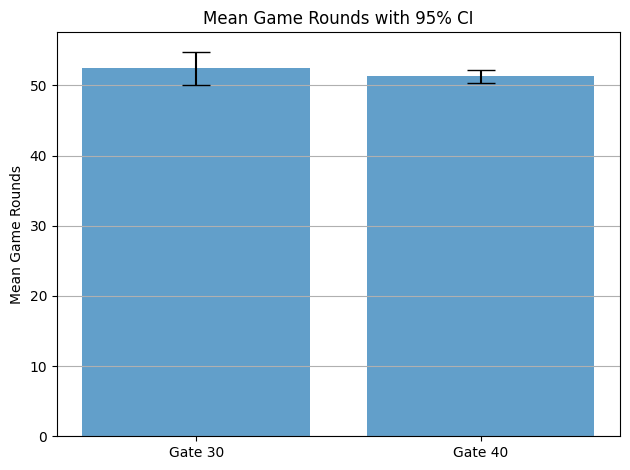

In [28]:
fig, ax = plt.subplots()

means = [mean_30, mean_40]
cis = [(mean_30 - ci_lower_30, ci_upper_30 - mean_30), (mean_40 - ci_lower_40, ci_upper_40 - mean_40)]
x_pos = np.arange(len(means))

ax.bar(x_pos, means, yerr=[ci[1] for ci in cis], align='center', alpha=0.7, ecolor='black', capsize=10)
ax.set_ylabel('Mean Game Rounds')
ax.set_xticks(x_pos)
ax.set_xticklabels(['Gate 30', 'Gate 40'])
ax.set_title('Mean Game Rounds with 95% CI')
ax.yaxis.grid(True)

plt.tight_layout()
plt.show()

### Summary
- The p-value of 0.4576 suggests that the observed difference in means is not statistically significant.

- Wilcoxon Rank-Sum Test p-value of 0.0503 is very close to 0.05, indicating a borderline result.\
While it is slightly greater than 0.05, it suggests that there is a marginal\
evidence of a difference in the distribution of "sum_gamerounds" between the\
gate_30 and gate_40 groups. The closeness of the p-value to 0.05 suggests that\
there might be a trend that warrants further investigation.

- Since the CI includes zero, we do not have enough evidence to conclude\
a significant difference in the mean number of game rounds played between\
the gate_30 and gate_40 groups.